In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pylab
import seaborn as sns

import nengo
from nengo.solvers import LstsqL2
from nengo.utils.numpy import rmse

import nengolib

Building finished in 0:00:02.                                                   
Simulating finished in 0:00:02.                                                 
89.04325 102.294294294


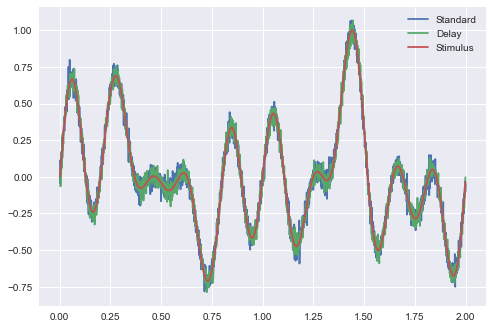

(0.043921197319934456, 0.038108176560398235)
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:01.                                 

In [216]:
def compare(n_neurons, freq=5., T=2.0, dt=0.001,
            theta=0.05, order=3,
            radii=0.12, radius=1.0,
            input_synapse=0.001, recurrent_synapse=0.001,
            reg=1e-2, probe=0, neuron_type=nengo.LIF(),
            plot=True):

    with nengolib.Network() as model:
        u = nengo.processes.WhiteSignal(T, high=freq, y0=0).run(T, dt=dt)
        u /= np.max(abs(u))
        #stim = nengo.Node(output=lambda t: np.sin(2*np.pi*freq*t))
        stim = nengo.Node(output=nengo.processes.PresentInput(u, dt))
        
        x_def = nengo.Ensemble(n_neurons, 1, neuron_type=neuron_type, radius=radius)
        x_ext = nengolib.networks.LinearNetwork(
            nengolib.synapses.PureDelay(theta, order), n_neurons // order,
            dt=dt, solver=LstsqL2(reg=reg),
            radii=radii, neuron_type=neuron_type,
            input_synapse=input_synapse, synapse=recurrent_synapse)
        
        nengo.Connection(stim, x_def, synapse=None)
        nengo.Connection(stim, x_ext.input, synapse=None)

        y_def = nengo.Node(size_in=1)
        y_ext = nengo.Node(size_in=1)

        nengo.Connection(x_def, y_def, synapse=None,
                         solver=LstsqL2(reg=reg))
        nengo.Connection(x_ext.x.output, y_ext, synapse=None,
                         transform=-x_ext.info['radii'][None, :])
        
        p_def = nengo.Probe(y_def, synapse=probe)
        p_ext = nengo.Probe(y_ext, synapse=probe)
        p_stim = nengo.Probe(stim, synapse=probe)

        if plot:
            p_def_neurons = nengo.Probe(x_def.neurons, synapse=None)
            p_ext_neurons = nengo.Probe(x_ext.x.add_neuron_output(), synapse=None)
    
    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)
        
    if plot:
        print np.mean(sim.data[p_def_neurons]), np.mean(sim.data[p_ext_neurons])
        
        pylab.figure()
        pylab.plot(sim.trange(), sim.data[p_def], label="Standard")
        pylab.plot(sim.trange(), sim.data[p_ext], label="Delay")
        pylab.plot(sim.trange(), sim.data[p_stim], label="Stimulus")
        pylab.legend()
        pylab.show()
        
    return (rmse(sim.data[p_def], sim.data[p_stim]),
            rmse(sim.data[p_ext], sim.data[p_stim]))

print compare(2000)

neurons = np.linspace(10, 1000, 10)
num_trials = 1
data = np.empty((len(neurons), num_trials, 2))

for i, n_neurons in enumerate(neurons):
    for j in range(num_trials):
        data[i, j, :] = compare(int(n_neurons), plot=False)

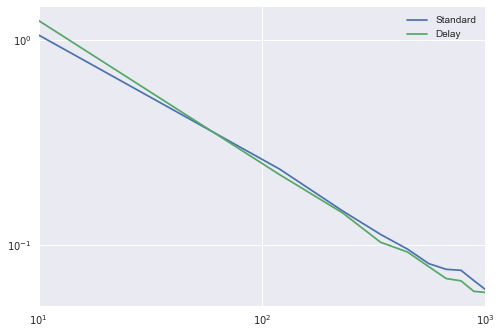

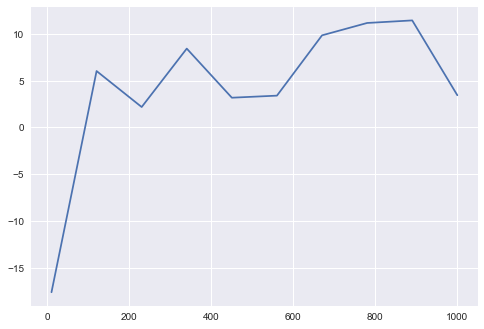

In [217]:
cpal = sns.color_palette(None, 2)

pylab.figure()
#pylab.loglog(neurons, data[:, :, 0], label="Standard")
#pylab.loglog(neurons, data[:, :, 1], label="Extension")
sns.tsplot(data[:, :, 0].T, neurons, err_style='ci_band', ci=99, color=cpal[0], condition="Standard")
sns.tsplot(data[:, :, 1].T, neurons, err_style='ci_band', ci=99, color=cpal[1], condition="Delay")
pylab.xscale('log')
pylab.yscale('log')
#pylab.loglog(neurons, 10/neurons, label=r"$1/n$")
#pylab.loglog(neurons, 100/neurons**2, label=r"$1/n^2$")
#pylab.plot(neurons, data[:, 0], label="Standard")
#pylab.plot(neurons, data[:, 1], label="Extension")
pylab.legend()
pylab.show()

old = np.mean(data[:, :, 0], axis=1)
new = np.mean(data[:, :, 1], axis=1)
pylab.figure()
pylab.plot(neurons, (old - new) / old * 100)
pylab.show()

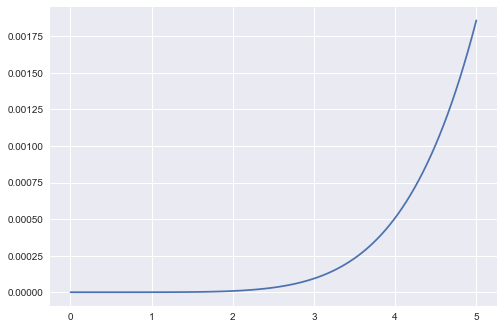

In [184]:
theta = 0.05
order = 3
sys = nengolib.synapses.PureDelay(theta, order)

freqs = np.linspace(0, 5, 100)
s = 2.j * np.pi * freqs

pylab.figure()
pylab.plot(freqs, abs(np.exp(-s*theta) - sys(s)))
pylab.show()